### Bayesian Entropy Neural Network - Regression problem


In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
from blitz.modules import BayesianLinear
from blitz.utils import variational_estimator
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.datasets import load_diabetes
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from torch_truncnorm.TruncatedNormal import TruncatedNormal

from function_collection import *

from functools import partial

# mdmm for constrained optimization
import mdmm

# tensorboard
from torch.utils.tensorboard import SummaryWriter

In [2]:
# create directory for tensorboard logs
import os
if not os.path.exists('regression_benn_logs'):
    os.makedirs('regression_benn_logs')
    


In [3]:

class HuberLoss(nn.Module):
    def __init__(self, delta=1.0):
        super(HuberLoss, self).__init__()
        self.delta = delta

    def forward(self, y_true, y_pred):
        error = y_true - y_pred
        huber_condition = torch.abs(error) < self.delta
        loss = torch.where(huber_condition,
                           0.5 * error.pow(2),
                           self.delta * (torch.abs(error) - 0.5 * self.delta))
        return torch.mean(loss)

def fencon(eta, N, regressor, x_test, y_test):
    '''
    Compute loss with a value constraint
    '''
    I1 = 0
    I2 = 0
    for i in range(N):
        g = regressor(x_test)
        I1 += g*torch.exp(eta*g) # This can explode if eta is too large
        I2 += torch.exp(eta*g)
    
    # err = torch.abs(I1/I2 - y_test)
    I1 = I1/N
    I2 = I2/N
    
    # compute MSE loss - I1/I2 and y_test
    crit = nn.MSELoss()
    err = crit(I1/I2, y_test)

    return err

In [4]:
# Bayesian Entropy Neural Network
# Define NN model
@variational_estimator
class BayesianRegressor(nn.Module):
    def __init__(self, input_dim, output_dim):
        super().__init__()
        self.posterior_rho_init = -3.0
        self.prior_sigma_1 = 40.0
        self.prior_sigma_2 = 50.0
        self.blinear1 = BayesianLinear(input_dim, 4096, bias = True, prior_dist = torch.distributions.Normal(torch.tensor(0.0).to(device = torch.device('cuda:0')),torch.tensor(3.0).to(device = torch.device('cuda:0'))))
        self.blinear2 = BayesianLinear(4096, output_dim, bias = True, prior_dist = torch.distributions.Normal(torch.tensor(0.0).to(device = torch.device('cuda:0')),torch.tensor(3.0).to(device = torch.device('cuda:0'))))

    def forward(self, x):
        x_ = self.blinear1(x)
        x_ = F.tanh(x_)
        x_ = self.blinear2(x_)
        return x_



In [5]:
# # Generate example data
# np.random.seed(0)
# X = np.linspace(-15, 15, 100).reshape(-1, 1)
# # y = 2 * X**3 - 3 * X + 2 * X + np.random.normal(0, 0.5, X.shape[0]).reshape(-1, 1)
# y = X*np.sin(X) + np.random.normal(0, 0.1, X.shape[0]).reshape(-1, 1)


# mask_start = -5
# mask_end = 5
# # Filter out data within the range [-0.5, 0.5] for the training set
# mask = (X > mask_start) & (X < mask_end)
# X_train = X[mask]
# y_train = y[mask]


# # Easiest example - Test set is the same function.
# mask = (X <= mask_start) | (X >= mask_end)
# X_test = X[mask]
# y_test = y[mask]

# # test f2 function from function_collection.py
# # X, y = f2()
# # X_train, y_train, X_test, y_test = mask(X, y, method = 'random', test_size = 0.2)

# # # Plot the data
# # plt.figure(figsize=(10, 6))
# # plt.scatter(X_train, y_train, color='blue', label='Training Data')
# # plt.scatter(X_test, y_test, color='green', label='Filtered Test Data')
# # plt.xlabel('X')
# # plt.ylabel('y')
# # plt.legend()
# # plt.show()


In [6]:
sig_e = 0.1
nobs = 36
x = 10*np.random.rand(nobs)
ndim = 1
nd = (ndim+1)*(ndim+2)//2
from quad_basis import quad_basis
import numpy as np
X = quad_basis(x)
e = sig_e*np.random.randn(nobs, 1)
beta_true = np.array([1,-2,1]).transpose().reshape(-1,1)
y = X@beta_true + e

X_train = x.reshape(-1,1)
y_train = y



In [7]:
def value_constraints(data):
    X_test = np.array([vc[0] for vc in data]).reshape(-1, 1)
    y_test = np.array([vc[1] for vc in data]).reshape(-1, 1)
    return np.concatenate((X_test, y_test), axis=0)

X_test, y_test = value_constraints([[40, 33]])


In [8]:
# Create dataloader for regression task
X_train, y_train = torch.tensor(X_train).float(), torch.tensor(y_train).float()
X_test, y_test = torch.tensor(X_test).float(), torch.tensor(y_test).float()

ds_train = torch.utils.data.TensorDataset(X_train, y_train)
dataloader_train = torch.utils.data.DataLoader(ds_train, batch_size=1000, shuffle=True)

ds_test = torch.utils.data.TensorDataset(X_test, y_test)
dataloader_test = torch.utils.data.DataLoader(ds_test, batch_size=1000, shuffle=True)

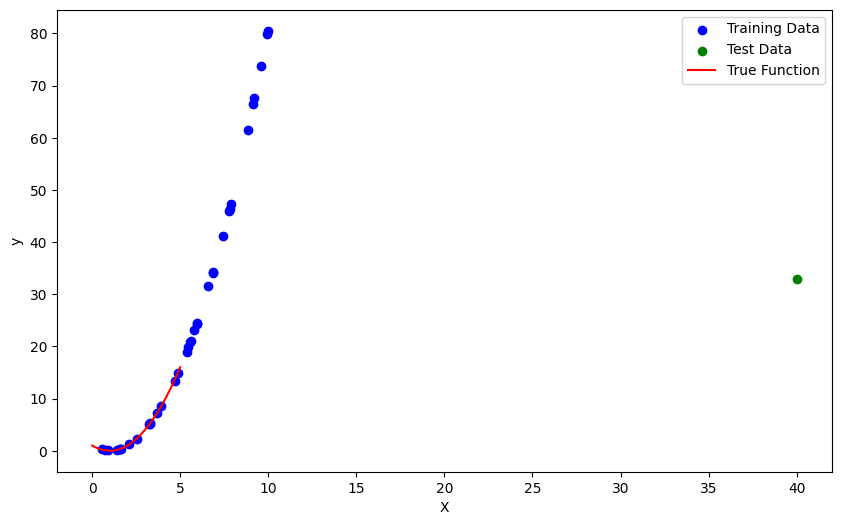

In [9]:
# Plot the training data and the true function 
plt.figure(figsize=(10, 6))
plt.scatter(X_train, y_train, color='blue', label='Training Data')
plt.scatter(X_test, y_test, color='green', label='Test Data')
# plot the true function 
x_plot = np.linspace(0, 5, 100)
y_plot = quad_basis(x_plot)@beta_true
plt.plot(x_plot, y_plot, color='red', label='True Function')
plt.xlabel('X')
plt.ylabel('y')
plt.legend()
plt.show()


In [10]:
next(iter(dataloader_train))[0].reshape(-1, 1).shape

torch.Size([36, 1])

In [11]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
regressor = BayesianRegressor(1, 1).to(device)

optimizer = optim.Adam(regressor.parameters(), lr=0.001)
# stepLR scheduler
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=200, gamma=0.25)
criterion = torch.nn.MSELoss()

regressor_benn = BayesianRegressor(1, 1).to(device)
optimizer_benn = optim.Adam(regressor_benn.parameters(), lr=0.001)
scheduler_benn = optim.lr_scheduler.StepLR(optimizer, step_size=300, gamma=0.25)

criterion_benn = torch.nn.MSELoss()


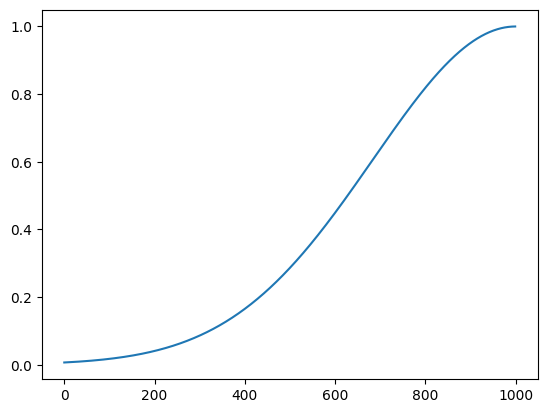

In [12]:
def sigmoid_rampup(current, rampup_length):
    """Exponential rampup from https://arxiv.org/abs/1610.02242"""
    if rampup_length == 0:
        return 1.0
    else:
        current = np.clip(current, 0.0, rampup_length)
        phase = 1.0 - current / rampup_length
        return float(np.exp(-5.0 * phase * phase))

# plot the rampup function
rampup_values = []

for i in range(1000):
    rampup_values.append(sigmoid_rampup(i, 1000))

plt.plot(rampup_values)
plt.show()

In [13]:
## Baseline result
# iteration = 0
# best_loss = 1e6
# regressor.train()
# for epoch in range(2500):
#     for i, (datapoints, labels) in enumerate(dataloader_train):
#         optimizer.zero_grad()
#         datapoints = datapoints.reshape(-1, 1).to(device)
#         labels = labels.reshape(-1, 1).to(device)
#         loss = regressor.sample_elbo(inputs=datapoints.to(device),
#                            labels=labels.to(device),
#                            criterion=criterion,
#                            sample_nbr=3,
#                            complexity_cost_weight=1/X_train.shape[0])
#         # loss = criterion(regressor(datapoints), labels)
#         loss.backward()
#         optimizer.step()
#         scheduler.step()
#         # check if the loss is lower than the best_loss
#         if loss < best_loss:
#             best_loss = loss
#             best_model = regressor
#             print("Best loss: {:.4f}".format(best_loss))
#             print('iteration: ', iteration)
        
#         iteration += 1
#         if iteration%10==0:
#         #     ic_acc, under_ci_upper, over_ci_lower = evaluate_regression(regressor,
#         #                                                                 X_test.reshape(-1,1).to(device),
#         #                                                                 y_test.reshape(-1,1).to(device),
#         #                                                                 samples=25,
#         #                                                                 std_multiplier=3)
            
            
#             # print("CI acc: {:.2f}, CI upper acc: {:.2f}, CI lower acc: {:.2f}".format(ic_acc, under_ci_upper, over_ci_lower))
#             print("Loss: {:.4f}".format(loss))


In [14]:
# initial guess for eta
eta = torch.tensor(1., requires_grad=True)

# optimizer and scheduler for eta - SGD w/ one cycle lr
optimizer_eta = optim.SGD([eta], lr=1e-5, momentum=0.9) # eta is a list of tensors
scheduler_eta = optim.lr_scheduler.StepLR(optimizer_eta, step_size=100, gamma=0.5)

# scheduler_eta = optim.lr_scheduler.CyclicLR(
#     optimizer_eta, base_lr = 1e-2, max_lr = 1e-1, step_size_up = 30,
#     step_size_down = 30, mode = 'triangular2'
# )


In [15]:
# define L1 loss
l1_loss = nn.L1Loss()

def value_constraint_loss(regressor, X_test, y_test):
    y_pred = regressor(X_test)
    return l1_loss(y_pred, y_test)

    

In [16]:
import time
from tracemalloc import start 

iteration = 0
best_loss = 1e6

N = 3
eps = 0.5
m = 10
regressor_benn.train()

eta_history = []
loss_history = []
loss_data_history = []
loss_constraint_history = []

best_loss = 1e9
# create summary writer based on datetime
import datetime
current_time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

writer = SummaryWriter('regression_benn_logs/' + current_time)

data_loss_weight = 1.0
constraint_loss_weight = sigmoid_rampup(iteration, 1000)
time_elapsed_ = []
for epoch in range(2500):
    for i, (datapoints, labels) in enumerate(dataloader_train):
        optimizer_benn.zero_grad()
        optimizer_eta.zero_grad()
        datapoints = datapoints.reshape(-1, 1).to(device)
        labels = labels.reshape(-1, 1).to(device)
        # loss_data = criterion(regressor_benn(datapoints), labels)
        start_time = time.time()
        loss_data = regressor_benn.sample_elbo(inputs=datapoints.to(device),
                           labels=labels.to(device),
                           criterion=criterion_benn,
                           sample_nbr=3,
                           complexity_cost_weight=1/X_train.shape[0])
        loss_constraint_1 = fencon(eta, N, regressor_benn, X_test.reshape(-1,1).to(device), y_test.reshape(-1,1).to(device))
        # dg, loss_constraint_2 = fencon2(eta, m, N, eps, regressor_benn, X_test_3a.reshape(-1,1).to(device), dy_test_3a.reshape(-1,1).to(device))
        # loss_constraint_3, var_g = fencon3(eta, N, regressor_benn, X_test_var.reshape(-1,1).to(device), y_test_var.reshape(-1,1).to(device))

        loss = 0.8*loss_data + 0.2*loss_constraint_1
        loss_data_history.append(loss_data.item())
        # eta needs to be logged to eta_history
        eta_history.append(eta.item())

        loss_constraint_history.append(loss_constraint_1.item())
        # loss_constraint_2_history.append(loss_constraint_2.item())
        # loss_constraint_3_history.append(loss_constraint_3.item())
        
        loss.backward()
        
        # optimizer_eta.step()
        # scheduler_eta.step()

        optimizer_benn.step()
        scheduler_benn.step()
        # ensure eta is between 0.1 and 1
        eta.data.clamp_(0.0, 1)
        # check if the loss is lower than the best_loss
        if loss < best_loss:
            best_loss = loss
            best_model_benn = regressor_benn
            print("Best loss: {:.4f}".format(best_loss.item()))
            print('iteration: ', iteration)
        iteration += 1
        end_time = time.time()
        time_elapsed_.append(end_time - start_time)
        print('Time elapsed: ', end_time - start_time)
        if iteration%1==0:
        #     ic_acc, under_ci_upper, over_ci_lower = evaluate_regression(regressor,
        #                                                                 X_test.reshape(-1,1).to(device),
        #                                                                 y_test.reshape(-1,1).to(device),
        #                                                                 samples=25,
        #                                                                 std_multiplier=3)
            
            
            # print("CI acc: {:.2f}, CI upper acc: {:.2f}, CI lower acc: {:.2f}".format(ic_acc, under_ci_upper, over_ci_lower))
            print("Total Loss: {:.4f}".format(loss.item()), "Val constraint loss: {:.4f}".format(loss_constraint_1.item()))
            # print("Total Loss: {:.4f}".format(loss.item()), "Val constraint loss: {:.4f}".format(loss_constraint_1.item()), "deriv constraint loss: {:.4f}".format(loss_constraint_2.item()), "derivative predicted: {:.4f}".format(dg.item()))
            # print("Total Loss: {:.4f}".format(loss), "Val constraint loss: {:.4f}".format(loss_constraint_1), "variance constraint loss: {:.4f}".format(loss_constraint_3))
            # print("Total Loss: {:.4f}".format(loss.item()), "Deriv constraint loss: {:.4f}".format(loss_constraint_2.item()),  "derivative predicted: {:.4f}".format(dg.item()))
            # print("Total Loss: {:.4f}".format(loss), "Val constraint loss: {:.4f}".format(loss_constraint_1), "eta: {:.4f}".format(eta))

# for epoch in range(2500):
#     for i, (datapoints, labels) in enumerate(dataloader_train):
#         optimizer_benn.zero_grad()
#         optimizer_eta.zero_grad()
#         datapoints = datapoints.reshape(-1, 1).to(device)
#         labels = labels.reshape(-1, 1).to(device)
#         start_time = time.time()
#         loss_data = regressor_benn.sample_elbo(inputs=datapoints.to(device),
#                            labels=labels.to(device),
#                            criterion=criterion_benn,
#                            sample_nbr=3,
#                            complexity_cost_weight=1/X_train.shape[0])
        
#         loss_constraint = value_constraint_loss(regressor_benn, X_test.reshape(-1,1).to(device), y_test.reshape(-1,1).to(device))
#         # step 1: given a guess for eta, compute the loss with value constraint
#         loss = loss_data - eta*loss_constraint
        
#         # update model 
#         loss.backward()
#         optimizer_benn.step()
#         optimizer_eta.step()

#         # check if the loss is lower than the best_loss
#         if loss < best_loss:
#             best_loss = loss
#             best_model = regressor_benn
        
#         # save history
#         eta_history.append(eta.item())
#         loss_history.append(loss.item())
#         loss_data_history.append(loss_data.item())
#         loss_constraint_history.append(loss_constraint.item())
#         iteration += 1
#         print('Time elapsed: ', time.time() - start_time)
#         if iteration%10==0:
#             print("loss_data: {:.4f}, loss_constraint: {:.4f}, eta: {:.4f}".format(loss_data.item(), loss_constraint.item(), eta.item()))
#             print('-----------------------------')
#             writer.add_scalar('Loss/loss_data', loss_data.item(), iteration)
#             writer.add_scalar('Loss/loss_constraint', loss_constraint.item(), iteration)
#             writer.add_scalar('Loss/eta', eta.item(), iteration)
#             writer.add_scalar('Loss/loss', loss.item(), iteration)
#             writer.flush()
#     scheduler_benn.step()
#     scheduler_eta.step()

/home/paralab/.local/lib/python3.8/site-packages/torch/nn/functional.py:1698: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/paralab/.local/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:129: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


Best loss: 3772.7698
iteration:  0
Time elapsed:  0.05153465270996094
Total Loss: 3772.7698 Val constraint loss: 1623.4658
Best loss: 3496.5859
iteration:  1
Time elapsed:  0.03949093818664551
Total Loss: 3496.5859 Val constraint loss: 1176.6351
Best loss: 3252.3689
iteration:  2
Time elapsed:  0.03979682922363281
Total Loss: 3252.3689 Val constraint loss: 794.8289
Best loss: 3039.4395
iteration:  3
Time elapsed:  0.03844881057739258
Total Loss: 3039.4395 Val constraint loss: 491.3348
Best loss: 2859.7434
iteration:  4
Time elapsed:  0.04143691062927246
Total Loss: 2859.7434 Val constraint loss: 265.2465
Best loss: 2710.7065
iteration:  5
Time elapsed:  0.04021954536437988
Total Loss: 2710.7065 Val constraint loss: 108.5532
Best loss: 2591.9185
iteration:  6
Time elapsed:  0.03862118721008301
Total Loss: 2591.9185 Val constraint loss: 23.4990
Best loss: 2507.6914
iteration:  7
Time elapsed:  0.03897356986999512
Total Loss: 2507.6914 Val constraint loss: 0.4584
Best loss: 2443.8813
iter

In [17]:
# mean time
print('Mean time elapsed: ', np.mean(time_elapsed_))


Mean time elapsed:  0.03872042016983032


In [20]:
loss_data_history = np.stack(loss_data_history)
loss_constraint_1_history = np.stack(loss_constraint_history)
eta_history = np.stack(eta_history)


Training loss:  tensor(0.9339, device='cuda:0', grad_fn=<MeanBackward0>)
Val constraint loss:  tensor(0.3906, device='cuda:0', grad_fn=<MeanBackward0>)


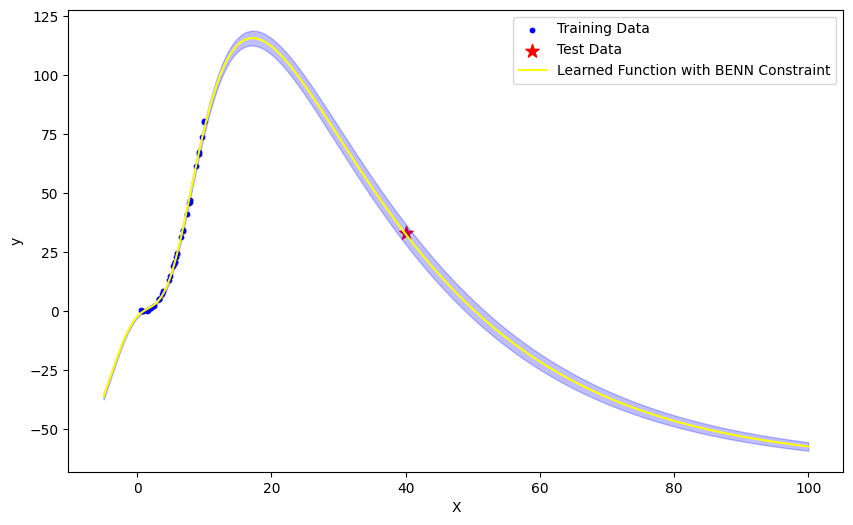

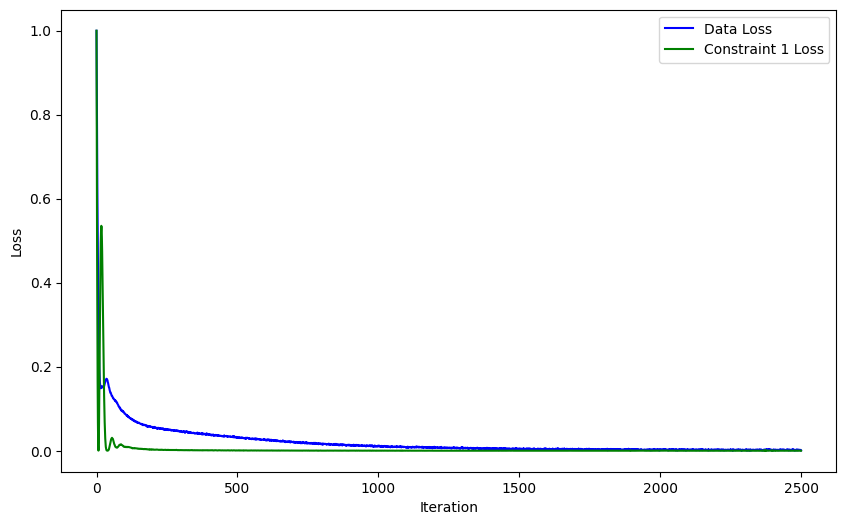

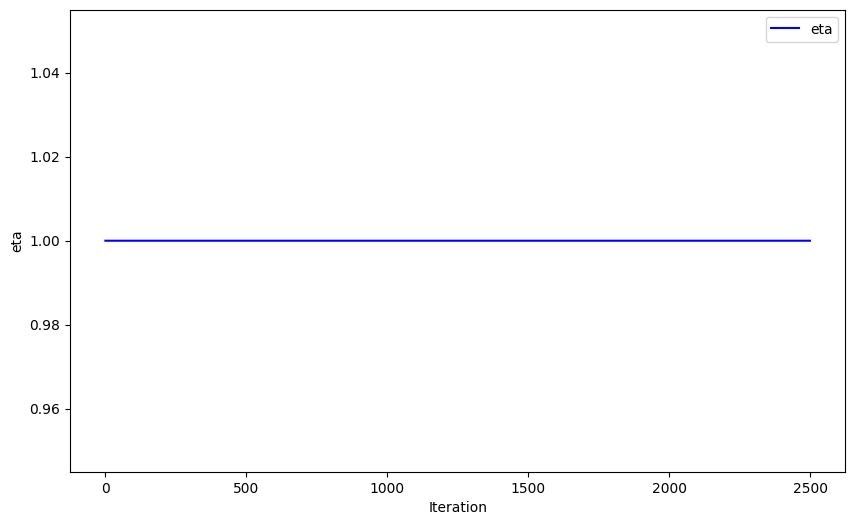

In [22]:
# Plot the training data, and the learned function using test data linearly spaced torch tensor
plt.figure(figsize=(10, 6))
# size of scatter points = 10, and test points need to be stars not circles
plt.scatter(X_train, y_train, color='blue', label='Training Data', s=10)
plt.scatter(X_test, y_test, color='red', label='Test Data', marker='*', s=100)

# linspaced test data
x_plot = torch.linspace(-5, 100, 1000).reshape(-1,1)

# y_plot = best_model(x_plot.to(device)).cpu().detach().numpy()
# preds = [best_model(x_plot.to(device)).cpu().detach().numpy() for _ in range(100)]
# preds = np.stack(preds)
# mean = preds.mean(axis=0)
# std = preds.std(axis=0)
# ci_upper = mean + (1 * std)
# ci_lower = mean - (1 * std)

# y_plot_benn = best_model_benn(x_plot.to(device)).cpu().detach().numpy()
preds_benn = [best_model_benn(x_plot.to(device)).cpu().detach().numpy() for _ in range(100)]
preds_benn = np.stack(preds_benn)
mean_benn = preds_benn.mean(axis=0)
std_benn = preds_benn.std(axis=0)
ci_upper_benn = mean_benn + (25*std_benn)
ci_lower_benn = mean_benn - (25*std_benn)

# Compute MSE loss on train, test set and constraint set
mae_loss = nn.L1Loss()
loss_training = []
loss_val_constraints = []
for i in range(100):
    loss_training.append(mae_loss(best_model_benn(X_train.to(device)), y_train.to(device)))
    loss_val_constraints.append(mae_loss(best_model_benn(X_test.to(device)).reshape(len(X_test),), y_test.to(device)))
print('Training loss: ', torch.stack(loss_training).mean())
print('Val constraint loss: ', torch.stack(loss_val_constraints).mean())

# extract x_plot values between 25 and 27
# x_plot_deriv = x_plot[(x_plot>=10) & (x_plot<=11)]
# # compute line with slope dy_test_3, and y-intercept at mean_benn of x_plot_deriv >= 25 and <= 25.50
# y_plot_deriv = dy_test_3*(x_plot_deriv)


# plt.plot(x_plot, mean, color='red', label='Learned Function')
# plt.fill_between(x_plot.squeeze(), ci_lower.squeeze(), ci_upper.squeeze(), color='orange', alpha=0.25)
plt.plot(x_plot, mean_benn, color='yellow', label='Learned Function with BENN Constraint')
plt.fill_between(x_plot.squeeze(), ci_lower_benn.squeeze(), ci_upper_benn.squeeze(), color='blue', alpha=0.25)
plt.xlabel('X')
plt.ylabel('y')
plt.legend()
plt.show()

# Plot loss histories 
loss_data_history = (loss_data_history - np.min(loss_data_history))/(np.max(loss_data_history) - np.min(loss_data_history))
loss_constraint_1_history = (loss_constraint_1_history - np.min(loss_constraint_1_history))/(np.max(loss_constraint_1_history) - np.min(loss_constraint_1_history))
# loss_constraint_2_history = (loss_constraint_2_history - min(loss_constraint_2_history))/(max(loss_constraint_2_history) - min(loss_constraint_2_history))
# loss_constraint_3_history   = (loss_constraint_3_history - min(loss_constraint_3_history))/(max(loss_constraint_3_history) - min(loss_constraint_3_history))
plt.figure(figsize=(10, 6))
plt.plot(loss_data_history, color='blue', label='Data Loss')
plt.plot(loss_constraint_1_history, color='green', label='Constraint 1 Loss')
# plt.plot(loss_constraint_2_history, color='red', label='Constraint 2 Loss')
# plt.plot(loss_constraint_3_history, color='yellow', label='Constraint 3 Loss')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot eta history
plt.figure(figsize=(10, 6))
plt.plot(eta_history, color='blue', label='eta')
plt.xlabel('Iteration')
plt.ylabel('eta')
plt.legend()
plt.show()


In [ ]:
# find the values of x_plot between 30 and 31
x_plot_ = x_plot[(x_plot>=30) & (x_plot<=31)]
# extract the corresponding values of mean_benn 
mean_benn_ = mean_benn[(x_plot>=30) & (x_plot<=31)]
print("x_plot_", x_plot_, 'mean_benn_: ', mean_benn_)


## Using BO-Torch to optimize eta and the model simultaneously


In [ ]:
def initialize_model():
    regressor_benn = BayesianRegressor(1, 1).to(device)
    return regressor_benn

def initialize_optimizer(model):
    optimizer_benn = optim.Adam(model.parameters(), lr=0.005)
    scheduler_benn = optim.lr_scheduler.StepLR(optimizer, step_size=300, gamma=0.25)
    return optimizer_benn, scheduler_benn

def compute_loss(datapoints, labels, model, eta):
    N = 3
    # loss_data = criterion(model(datapoints), labels)
    loss_data = model.sample_elbo(inputs=datapoints.to(device),
                           labels=labels.to(device),
                           criterion=criterion_benn,
                           sample_nbr=3,
                           complexity_cost_weight=1/X_train.shape[0])
    loss_constraint_1 = fencon(eta, N, model, X_test.reshape(-1,1).to(device), y_test.reshape(-1,1).to(device))
    # loss_constraint_2 = fencon3(eta, N, model, X_test_3.reshape(-1,1).to(device), dy_test_3.reshape(-1,1).to(device))
    # loss = loss_data + loss_constraint_1 + loss_constraint_2
    loss = loss_data + loss_constraint_1
    return loss


In [ ]:
from botorch import fit_gpytorch_model
from botorch.models import SingleTaskGP
from botorch.optim import optimize_acqf
from botorch.acquisition import ExpectedImprovement
from gpytorch.mlls import ExactMarginalLogLikelihood

# Define your objective function (validation loss in this case)
num_epochs = 2
def objective(eta):
    model = initialize_model()
    optimizer, scheduler = initialize_optimizer(model)
    best_loss = 1e6
    for epoch in range(num_epochs):
        for i, (datapoints, labels) in enumerate(dataloader_train):
            optimizer.zero_grad()
            loss = compute_loss(datapoints, labels, model, eta)
            loss.backward()
            optimizer.step()
            # check if the loss is lower than the best_loss
        if loss < best_loss:
            best_loss = loss
            best_model_benn = regressor_benn
            print("Best loss: {:.4f}".format(best_loss))
            print('iteration: ', epoch)
    

    # validation_loss = compute_validation_loss(validation_data, model)
    return loss.item()


# Define the range for eta
eta_lower = 0.1
eta_upper = 0.9

# Create training data for eta
eta_range = torch.linspace(eta_lower, eta_upper, steps=50).reshape(-1, 1)  # Adjust the number of steps as needed

# Create corresponding target values using the objective function
train_X = eta_range
train_Y = torch.tensor([objective(eta.item()) for eta in eta_range], dtype=torch.float).reshape(-1, 1)
# Initialize the SingleTaskGP model
model = SingleTaskGP(train_X, train_Y)

# Define the acquisition function
acquisition = ExpectedImprovement(model, best_f = 0.2, maximize=False)

# Optimize the acquisition function
best_eta, _ = optimize_acqf(
    acq_function=acquisition,
    bounds=torch.tensor([[eta_lower], [eta_upper]]),  # eta values are bounded between 0.1 and 0.9
    q=1,  # Number of candidates to select
    num_restarts=10,  # Number of optimization restarts
    raw_samples=500,  # Number of random samples for initialization
)

print("Best eta:", best_eta.item())


In [ ]:
# Plot the training data, and the learned function using test data linearly spaced torch tensor
plt.figure(figsize=(10, 6))
# size of scatter points = 10, and test points need to be stars not circles
plt.scatter(X_train, y_train, color='blue', label='Training Data', s=10)
plt.scatter(X_test, y_test, color='red', label='Test Data', marker='*', s=100)

# linspaced test data
x_plot = torch.linspace(-25, 100, 500).reshape(-1,1)

# y_plot = best_model(x_plot.to(device)).cpu().detach().numpy()
# preds = [best_model(x_plot.to(device)).cpu().detach().numpy() for _ in range(100)]
# preds = np.stack(preds)
# mean = preds.mean(axis=0)
# std = preds.std(axis=0)
# ci_upper = mean + (1 * std)
# ci_lower = mean - (1 * std)

# y_plot_benn = best_model_benn(x_plot.to(device)).cpu().detach().numpy()
preds_benn = [best_model_benn(x_plot.to(device)).cpu().detach().numpy() for _ in range(100)]
preds_benn = np.stack(preds_benn)
mean_benn = preds_benn.mean(axis=0)
std_benn = preds_benn.std(axis=0)
ci_upper_benn = mean_benn + (1*std_benn)
ci_lower_benn = mean_benn - (1*std_benn)

# extract x_plot values between 25 and 27
# x_plot_deriv = x_plot[(x_plot>=10) & (x_plot<=11)]
# # compute line with slope dy_test_3, and y-intercept at mean_benn of x_plot_deriv >= 25 and <= 25.50
# y_plot_deriv = dy_test_3*(x_plot_deriv)


# plt.plot(x_plot, mean, color='red', label='Learned Function')
# plt.fill_between(x_plot.squeeze(), ci_lower.squeeze(), ci_upper.squeeze(), color='orange', alpha=0.25)
plt.plot(x_plot, mean_benn, color='yellow', label='Learned Function with BENN Constraint')
plt.fill_between(x_plot.squeeze(), ci_lower_benn.squeeze(), ci_upper_benn.squeeze(), color='blue', alpha=0.25)
plt.xlabel('X')
plt.ylabel('y')
plt.legend()
plt.show()

# # Plot loss histories 
# loss_data_history = (loss_data_history - np.min(loss_data_history))/(np.max(loss_data_history) - np.min(loss_data_history))
# loss_constraint_1_history = (loss_constraint_1_history - np.min(loss_constraint_1_history))/(np.max(loss_constraint_1_history) - np.min(loss_constraint_1_history))
# # loss_constraint_2_history = (loss_constraint_2_history - min(loss_constraint_2_history))/(max(loss_constraint_2_history) - min(loss_constraint_2_history))

# plt.figure(figsize=(10, 6))
# plt.plot(loss_data_history, color='blue', label='Data Loss')
# plt.plot(loss_constraint_1_history, color='green', label='Constraint 1 Loss')
# # # plt.plot(loss_constraint_2_history.cpu().detach().numpy(), color='red', label='Constraint 2 Loss')
# plt.xlabel('Iteration')
# plt.ylabel('Loss')
# plt.legend()
# plt.show()

# # Plot eta history
# plt.figure(figsize=(10, 6))
# plt.plot(eta_history, color='blue', label='eta')
# plt.xlabel('Iteration')
# plt.ylabel('eta')
# plt.legend()
# plt.show()
